# Time Series forecasting fundamentals with tensorflow + Milestone projet 3: BitPredict

Time series problems deal with data over time.

https://otexts.com/fpp3/

https://www.uber.com/en-FR/blog/forecasting-introduction/

<img src="course_images/10_time_series/10-example-time-series-problems.png" height="500">

<img src="course_images/10_time_series/time_series_inputs_and_outputs.png" height="500">

<img src="course_images/10_time_series/bitpredict_input_and_output_shape.png" height="500">

Let's write some Tensorflow code to predict the price of Bitcoin based on the historical price of Bitcoin

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin


https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

## importing time series pandas

In [125]:
# import with pandas
import pandas as pd
# read in our Bitcoin data and parse the dates
df = pd.read_csv("data/time_series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [127]:
# how many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

<img src="course_images/10_time_series/10-types-of-time-series-patterns.png" height="500">

<img src="course_images/10_time_series/univariate_and_multivariate_time_series_data.png" height="500">

In [128]:
# only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


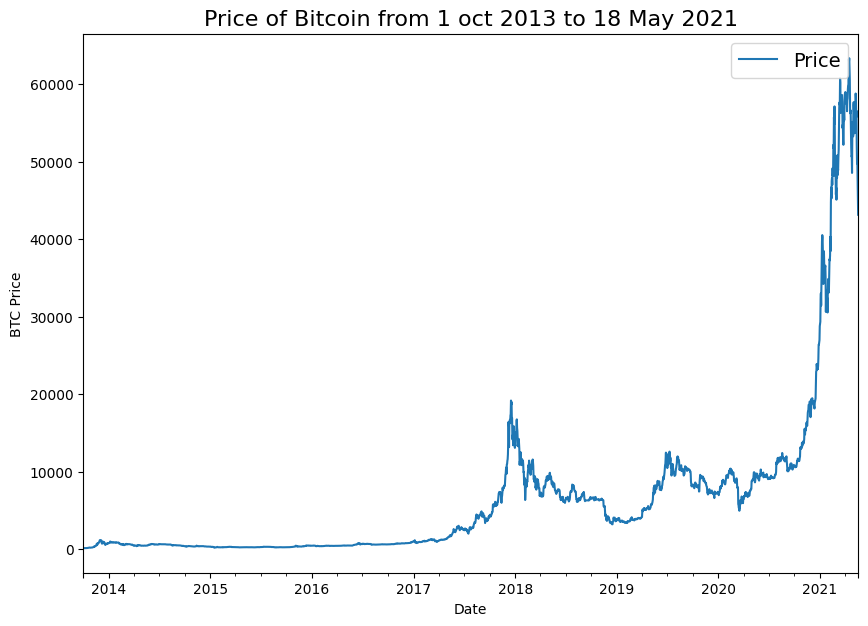

In [129]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Importing time series data with Python's CSV module

In [130]:
# importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("./data/time_series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader) # skip first line (this gets rid of the column titles (header))
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
        btc_price.append(float(line[2])) # get the closing price as float

# viex first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

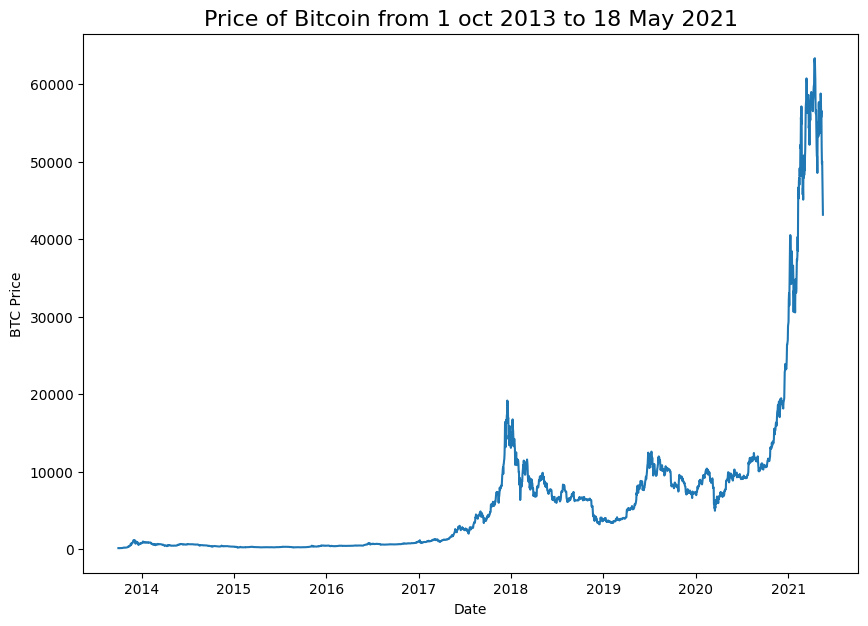

In [131]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [132]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [133]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, #dates
                                                    prices, # BTC prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test

((2229,),
 (558,),
 (2229,),
 array([ 7954.00623772, 56427.04312502,  4186.78374   ,  9906.40796505,
        10983.21600203,   618.79      ,  9737.45855879,   519.015     ,
        11452.23      ,   602.4075    ,  1004.71375   ,   705.47125   ,
          277.853     ,   264.98625   ,  9917.24841434, 11261.80633174,
        15632.41125   ,   509.70665   ,   332.471     ,   445.327     ,
        10272.9025    , 11833.8973487 ,  3782.66410112, 10381.85595925,
         6396.35212354,  6280.31010688, 11742.94125   ,   407.473     ,
        10551.13163333,  1245.892     ,  3763.6205158 ,   238.06125   ,
        11802.95996359,   270.07587   , 10367.52799811,   609.495     ,
        47500.8975242 ,   455.28316   ,   304.9905    ,   620.59875   ,
          226.30419   , 10818.50700762, 29111.52156712, 56300.33410863,
          349.138     ,   728.36125   ,   644.091     ,   637.01625   ,
          511.4725    ,   376.59      ,  1196.896     ,   414.458     ,
          443.681     , 11358.70637

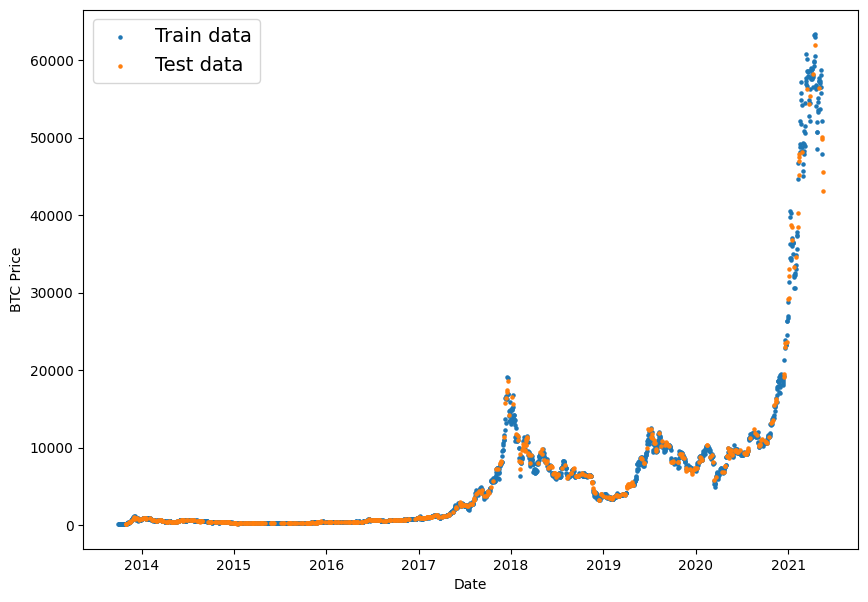

In [134]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

<img src="course_images/10_time_series/time_series_train_and_sets.png" height="500">

### Create train and test sets for time series (the right way)

In [135]:
# create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed (eg. 90/10, 95/5)

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

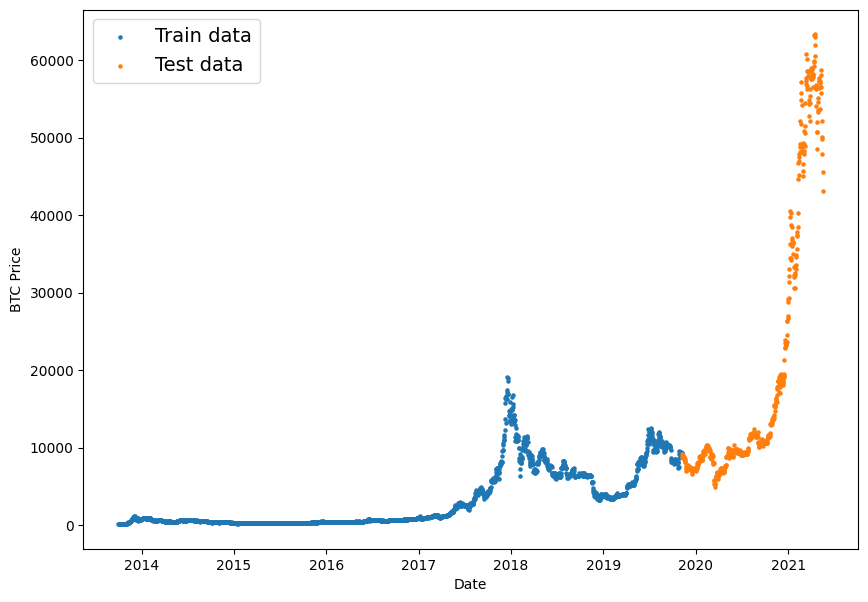

In [136]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it

In [137]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values accross time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot
    label : label to show on plot about values, default None
    """
    # Plot series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

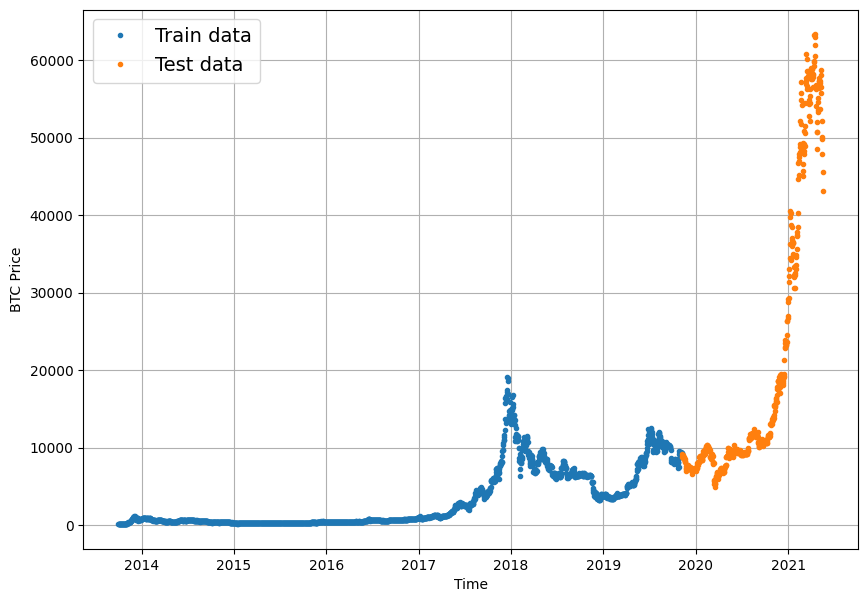

In [138]:
# Test out plotting function
plt.figure(figsize=(10,7)) # we create 1 figure, then we add 2 plot
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which performs the best.

* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 	Naïve model (baseline)
* 1 	Dense model, window = 1, horizon = 7
* 2 	Same as 1, window = 30, horizon= 1
* 3 	Same as 1, window = 30, horizon= 7
* 4 	Conv1D
* 5 	LSTM
* 6 	Same as 1 (but with multivariate data)
* 7 	N-BEATs Algorithm
* 8 	Ensemble (multiple models optimized on different loss functions)
* 9 	Future prediction model (model to predict future values)
* 10 	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [139]:
# Create a native forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

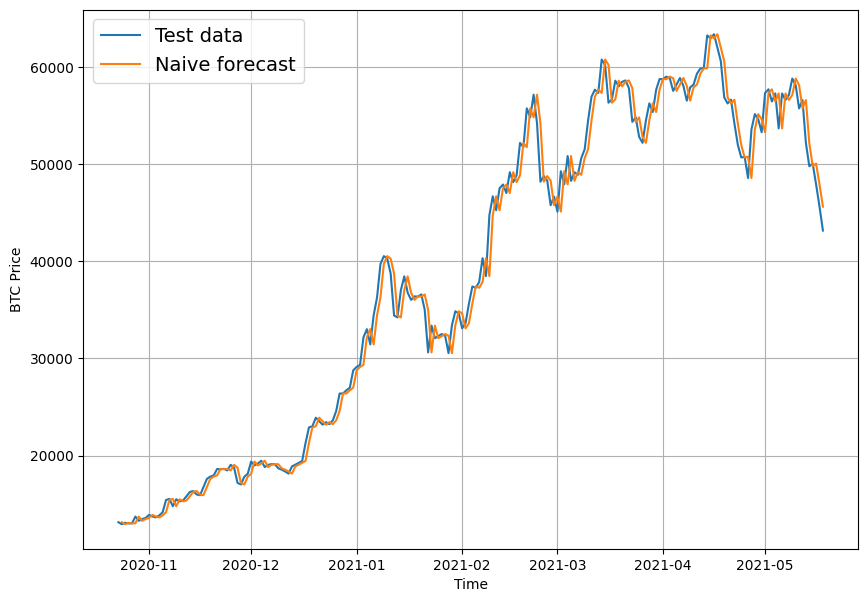

In [140]:
plt.figure(figsize=(10,7)) # we create 1 figure, then we add 2 plot
#plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicating a number, so that means we have a fomr of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* **MAE** - mean absolute error
* **MSE** - mean squarred error
* **RMSE** - root mean square error
* **MAPE/sMAPE** - (symmetric) mean absolute percentage error
* **MASE** - mean absolute scaled error

For all of the above metrics, **lower is better**

📖 https://otexts.com/fpp3/accuracy.html

<img src="course_images/10_time_series/commons_time_series_evaluation_metrics.png" height="500">

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [141]:
import tensorflow as tf

In [142]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [143]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

In [144]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


In [145]:
naive_results = evaluate_preds(y_true=y_test[1:],
                              y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecating models you may want to experiment with:

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts


## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [146]:
len(y_train)

2229

In [147]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}") 

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [148]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [149]:
# Create function de label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    creates label for windowed dataset.

    E.g if Horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [150]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


<img src="course_images/10_time_series/10-time-series-windows-and-horizons.png" height="500">

<img src="http://eng.uber.com/wp-content/uploads/2018/09/image6-e1536165830511.png?uclick_id=4cf2e7cd-e97f-42c9-bf37-d6e6cea5531a" height="500">


We've got a way to label our windowed data.

However, this only work on a small scale.

We need a way to do the above accros our entire time series.

We could do this with Python for loops, however , for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing. - https://numpy.org/doc/stable/user/arrays.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> 📖 **Resource**: The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [151]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D aray into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of a specific windows_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps ( minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # Create a 2D array of windows of size window_size
    #print(f"window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    #print(windowed_array)

    # 4. Get the labelles windows
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels


In [152]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [153]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [154]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


🔑 **Note**: There is a function which does similar to the above in tf.keras.preprocessing, an extension could be try and replicate what w've done using the premade function.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [155]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [156]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [157]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [158]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For exmaple if our model performs the best on epoech 55 (but we're train for 100 epochs), we want to lad and evaluate the model saved on epoch 55.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [159]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor="val_loss",
        verbose=0, # only output a limited amount of text
        save_best_only=True
    )

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values ?

Experimentation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own

In [160]:
import tensorflow as tf
import keras
from keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear = same output as before last output(same as having no activation)
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128, # adjustable acconrding to the size of our sample (for 1 image, it is big, for us we have windows of 7 ())
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 6s - loss: 3030.7383 - mae: 3030.7383 - mse: 18918594.0000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 28ms/step - loss: 1151.3424 - mae: 1151.3424 - mse: 4984947.5000 - val_loss: 2795.5469 - val_mae: 2795.5469 - val_mse: 17662500.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 413.7601 - mae: 413.7601 - mse: 780917.4375INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 289.6306 - mae: 289.6306 - mse: 361953.6250 - val_loss: 999.3126 - val_mae: 999.3126 - val_mse: 3348589.7500
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1765 - mae: 134.1765 - mse: 69738.1719INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 193.4790 - mae: 193.4790 - mse: 178328.1562 - val_loss: 984.4655 - val_mae: 984.4655 - val_mse: 3168351.7500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 218.3420 - mae: 218.3420 - mse: 243267.6875INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 180.3644 - mae: 180.3644 - mse: 170113.0000 - val_loss: 947.3606 - val_mae: 947.3606 - val_mse: 3019382.2500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 175.9755 - mae: 175.9755 - mse: 110233.8594INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 170.9996 - mae: 170.9996 - mse: 155645.5781 - val_loss: 939.2979 - val_mae: 939.2979 - val_mse: 2858204.5000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 124.2366 - mae: 124.2366 - mse: 59916.5742INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 24ms/step - loss: 168.1726 - mae: 168.1726 - mse: 149042.1406 - val_loss: 904.5242 - val_mae: 904.5241 - val_mse: 2760603.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 193.8137 - mae: 193.8137 - mse: 281037.3125

18/18 [==============================] - 0s 3ms/step - loss: 161.0889 - mae: 161.0889 - mse: 139281.1719 - val_loss: 911.2661 - val_mae: 911.2661 - val_mse: 2629396.2500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4972 - mae: 134.4972 - mse: 69240.2734INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 22ms/step - loss: 156.2197 - mae: 156.2197 - mse: 133435.2812 - val_loss: 858.0871 - val_mae: 858.0871 - val_mse: 2438303.2500
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 132.1433 - mae: 132.1433 - mse: 82161.9688INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 152.0936 - mae: 152.0936 - mse: 126914.6875 - val_loss: 837.7438 - val_mae: 837.7438 - val_mse: 2235052.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7598 - mae: 155.7598 - mse: 179946.0625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 149.2458 - mae: 149.2458 - mse: 123459.9141 - val_loss: 800.5889 - val_mae: 800.5889 - val_mse: 2102718.2500
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 143.2092 - mae: 143.2092 - mse: 114221.2031 - val_loss: 807.0508 - val_mae: 807.0508 - val_mse: 2042559.2500
Epoch 12/100
18/18 [==============================] - 0s 3ms/step - loss: 140.3362 - mae: 140.3362 - mse: 110332.2031 - val_loss: 859.2429 - val_mae: 859.2429 - val_mse: 2150836.7500
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 141.2550 - mae: 141.2550 - mse: 110690.1406 - val_loss: 811.0020 - val_mae: 811.0020 - val_mse: 1981151.5000
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 135.1094 - mae: 135.1094 - mse: 102845.1875 - val_loss: 805.9670 - val_mae: 805.9670 - val_mse: 1940146.6250
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 145.0237 - mae: 145.0237 - 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 135.1204 - mae: 135.1204 - mse: 101896.2266 - val_loss: 717.6878 - val_mae: 717.6878 - val_mse: 1725626.1250
Epoch 16/100
18/18 [==============================] - 0s 3ms/step - loss: 130.0645 - mae: 130.0645 - mse: 96951.7344 - val_loss: 745.1596 - val_mae: 745.1596 - val_mse: 1730104.0000
Epoch 17/100
18/18 [==============================] - 0s 3ms/step - loss: 128.5097 - mae: 128.5097 - mse: 94137.9844 - val_loss: 750.7831 - val_mae: 750.7831 - val_mse: 1727310.1250
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 146.5271 - mae: 146.5271 - mse: 112126.4062INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 127.9479 - mae: 127.9479 - mse: 93996.1172 - val_loss: 700.3743 - val_mae: 700.3743 - val_mse: 1596452.0000
Epoch 19/100
18/18 [==============================] - 0s 3ms/step - loss: 125.7582 - mae: 125.7582 - mse: 91677.5000 - val_loss: 706.7156 - val_mae: 706.7156 - val_mse: 1593743.8750
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 136.5609 - mae: 136.5609 - mse: 103028.4844INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 123.8255 - mae: 123.8255 - mse: 90074.6484 - val_loss: 676.5428 - val_mae: 676.5428 - val_mse: 1527934.5000
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 135.5307 - mae: 135.5307 - mse: 86168.3359INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 127.3817 - mae: 127.3817 - mse: 92713.9062 - val_loss: 665.1163 - val_mae: 665.1163 - val_mse: 1501641.8750
Epoch 22/100
18/18 [==============================] - 0s 3ms/step - loss: 126.3881 - mae: 126.3881 - mse: 90863.4766 - val_loss: 724.9664 - val_mae: 724.9664 - val_mse: 1614736.8750
Epoch 23/100
18/18 [==============================] - 0s 3ms/step - loss: 129.0075 - mae: 129.0075 - mse: 91541.1797 - val_loss: 694.9037 - val_mae: 694.9037 - val_mse: 1534011.8750
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 133.4638 - mae: 133.4638 - mse: 87697.1250INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 122.3819 - mae: 122.3819 - mse: 87097.3984 - val_loss: 650.6418 - val_mae: 650.6418 - val_mse: 1454869.8750
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 131.4941 - mae: 131.4941 - mse: 67070.5234INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 120.6282 - mae: 120.6282 - mse: 85157.0625 - val_loss: 646.9995 - val_mae: 646.9995 - val_mse: 1442857.6250
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 120.8276 - mae: 120.8276 - mse: 85318.5469 - val_loss: 647.4589 - val_mae: 647.4589 - val_mse: 1417200.0000
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 165.9818 - mae: 165.9818 - mse: 132312.9375INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 122.4793 - mae: 122.4793 - mse: 84884.9531 - val_loss: 637.9294 - val_mae: 637.9294 - val_mse: 1396678.2500
Epoch 28/100
18/18 [==============================] - 0s 3ms/step - loss: 118.5908 - mae: 118.5908 - mse: 83206.7969 - val_loss: 642.0479 - val_mae: 642.0479 - val_mse: 1394833.7500
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 114.6633 - mae: 114.6633 - mse: 86029.4062INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 119.9222 - mae: 119.9222 - mse: 83729.9922 - val_loss: 630.5175 - val_mae: 630.5175 - val_mse: 1378865.1250
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 121.1951 - mae: 121.1951 - mse: 83462.0625 - val_loss: 632.1421 - val_mae: 632.1421 - val_mse: 1383279.2500
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 121.6897 - mae: 121.6897 - mse: 82180.7422 - val_loss: 697.6756 - val_mae: 697.6756 - val_mse: 1511803.7500
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 123.0744 - mae: 123.0744 - mse: 78835.9531INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 119.5011 - mae: 119.5011 - mse: 84212.8281 - val_loss: 623.1819 - val_mae: 623.1819 - val_mse: 1344716.8750
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 117.0874 - mae: 117.0874 - mse: 80779.2031 - val_loss: 673.3233 - val_mae: 673.3233 - val_mse: 1445706.6250
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.9669 - mae: 142.9669 - mse: 130480.2031INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 116.8347 - mae: 116.8347 - mse: 81380.3438 - val_loss: 619.7972 - val_mae: 619.7972 - val_mse: 1340173.1250
Epoch 35/100
18/18 [==============================] - 0s 3ms/step - loss: 115.3658 - mae: 115.3658 - mse: 80210.4297 - val_loss: 627.0325 - val_mae: 627.0325 - val_mse: 1364308.3750
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 158.3717 - mae: 158.3717 - mse: 151324.8906INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 117.1094 - mae: 117.1094 - mse: 79954.1641 - val_loss: 616.9705 - val_mae: 616.9705 - val_mse: 1329498.8750
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 116.4167 - mae: 116.4167 - mse: 80184.5156 - val_loss: 652.6432 - val_mae: 652.6432 - val_mse: 1386337.6250
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 105.7574 - mae: 105.7574 - mse: 66944.5625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 115.7911 - mae: 115.7911 - mse: 78880.7500 - val_loss: 608.6262 - val_mae: 608.6262 - val_mse: 1303247.3750
Epoch 39/100
18/18 [==============================] - 0s 3ms/step - loss: 115.6095 - mae: 115.6095 - mse: 79451.4062 - val_loss: 617.9276 - val_mae: 617.9276 - val_mse: 1330348.8750
Epoch 40/100
18/18 [==============================] - 0s 3ms/step - loss: 113.1958 - mae: 113.1958 - mse: 76843.0312 - val_loss: 611.8768 - val_mae: 611.8768 - val_mse: 1311602.5000
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 114.0449 - mae: 114.0449 - mse: 76818.1250 - val_loss: 618.9482 - val_mae: 618.9482 - val_mse: 1303461.7500
Epoch 42/100
18/18 [==============================] - 0s 3ms/step - loss: 118.1514 - mae: 118.1514 - mse: 81067.8047 - val_loss: 627.1219 - val_mae: 627.1219 - val_mse: 1317810.1250
Epoch 43/100
18/18 [==============================] - 0s 3ms/step - loss: 116.4444 - mae: 116.4444 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 117.7573 - mae: 117.7573 - mse: 78062.0469 - val_loss: 597.8444 - val_mae: 597.8444 - val_mse: 1264066.1250
Epoch 45/100
18/18 [==============================] - 0s 3ms/step - loss: 112.3328 - mae: 112.3328 - mse: 76445.7109 - val_loss: 602.1189 - val_mae: 602.1189 - val_mse: 1279397.6250
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 86.3601 - mae: 86.3601 - mse: 46130.3047INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 112.8813 - mae: 112.8813 - mse: 75587.8828 - val_loss: 594.7062 - val_mae: 594.7062 - val_mse: 1259043.5000
Epoch 47/100
18/18 [==============================] - 0s 3ms/step - loss: 111.5120 - mae: 111.5120 - mse: 75449.8906 - val_loss: 643.0566 - val_mae: 643.0566 - val_mse: 1342638.1250
Epoch 48/100
18/18 [==============================] - 0s 3ms/step - loss: 112.0963 - mae: 112.0963 - mse: 75509.6953 - val_loss: 613.9249 - val_mae: 613.9249 - val_mse: 1279088.2500
Epoch 49/100
18/18 [==============================] - 0s 3ms/step - loss: 114.3524 - mae: 114.3524 - mse: 76124.7578 - val_loss: 630.5873 - val_mae: 630.5873 - val_mse: 1312536.8750
Epoch 50/100
18/18 [==============================] - 0s 3ms/step - loss: 116.8600 - mae: 116.8600 - mse: 77065.0234 - val_loss: 666.8947 - val_mae: 666.8947 - val_mse: 1442276.8750
Epoch 51/100
18/18 [==============================] - 0s 3ms/step - loss: 113.7349 - mae: 113.7349 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 112.8218 - mae: 112.8218 - mse: 75482.2422 - val_loss: 586.8019 - val_mae: 586.8019 - val_mse: 1229654.5000
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 112.8220 - mae: 112.8220 - mse: 75629.0469 - val_loss: 613.4713 - val_mae: 613.4713 - val_mse: 1271423.1250
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 104.1127 - mae: 104.1127 - mse: 71168.9141INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 111.9094 - mae: 111.9094 - mse: 74144.2031 - val_loss: 585.1911 - val_mae: 585.1911 - val_mse: 1226654.0000
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 113.4999 - mae: 113.4999 - mse: 76899.0469 - val_loss: 618.1023 - val_mae: 618.1023 - val_mse: 1278689.6250
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5534 - mae: 114.5534 - mse: 75365.6562 - val_loss: 833.2775 - val_mae: 833.2775 - val_mse: 1979685.2500
Epoch 57/100
18/18 [==============================] - 0s 3ms/step - loss: 130.3348 - mae: 130.3348 - mse: 88461.5703 - val_loss: 690.9345 - val_mae: 690.9345 - val_mse: 1501242.0000
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 121.8655 - mae: 121.8655 - mse: 77393.1719 - val_loss: 593.6185 - val_mae: 593.6185 - val_mse: 1231470.2500
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 111.9944 - mae: 111.9944 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 110.9911 - mae: 110.9911 - mse: 74298.5078 - val_loss: 580.1192 - val_mae: 580.1192 - val_mse: 1210740.3750
Epoch 62/100
18/18 [==============================] - 0s 3ms/step - loss: 107.7896 - mae: 107.7896 - mse: 71146.4062 - val_loss: 587.5483 - val_mae: 587.5483 - val_mse: 1216807.3750
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 109.1292 - mae: 109.1292 - mse: 71772.1016 - val_loss: 595.4860 - val_mae: 595.4860 - val_mse: 1228966.8750
Epoch 64/100
18/18 [==============================] - 0s 3ms/step - loss: 110.6707 - mae: 110.6707 - mse: 73044.5859 - val_loss: 594.0659 - val_mae: 594.0659 - val_mse: 1226836.5000
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 127.1150 - mae: 127.1150 - mse: 152286.6250INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 18ms/step - loss: 110.5316 - mae: 110.5316 - mse: 73627.4922 - val_loss: 578.0367 - val_mae: 578.0367 - val_mse: 1205161.1250
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 112.1730 - mae: 112.1730 - mse: 73504.8281INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 108.0970 - mae: 108.0970 - mse: 71398.0000 - val_loss: 575.9259 - val_mae: 575.9259 - val_mse: 1196386.3750
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 107.5284 - mae: 107.5284 - mse: 70555.1016 - val_loss: 623.1089 - val_mae: 623.1089 - val_mse: 1307739.7500
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 110.6861 - mae: 110.6861 - mse: 70767.6016 - val_loss: 593.2531 - val_mae: 593.2531 - val_mse: 1241104.3750
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 114.8616 - mae: 114.8616 - mse: 73542.0391 - val_loss: 672.8065 - val_mae: 672.8065 - val_mse: 1392018.7500
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 119.4207 - mae: 119.4207 - mse: 76090.4375 - val_loss: 591.1063 - val_mae: 591.1063 - val_mse: 1238767.2500
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 109.3888 - mae: 109.3888 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 111.3619 - mae: 111.3619 - mse: 72904.6797 - val_loss: 573.9739 - val_mae: 573.9739 - val_mse: 1190087.8750
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 113.9561 - mae: 113.9561 - mse: 74043.2578 - val_loss: 593.4192 - val_mae: 593.4192 - val_mse: 1239281.3750
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 111.1304 - mae: 111.1304 - mse: 72802.9219 - val_loss: 592.3753 - val_mae: 592.3753 - val_mse: 1233677.8750
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 112.8099 - mae: 112.8099 - mse: 72931.5078 - val_loss: 639.4336 - val_mae: 639.4336 - val_mse: 1313008.7500
Epoch 76/100
18/18 [==============================] - 0s 3ms/step - loss: 116.5531 - mae: 116.5531 - mse: 76358.2734 - val_loss: 641.1815 - val_mae: 641.1815 - val_mse: 1342790.1250
Epoch 77/100
18/18 [==============================] - 0s 3ms/step - loss: 108.3639 - mae: 108.3639 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 48ms/step - loss: 117.7809 - mae: 117.7809 - mse: 78286.8359 - val_loss: 570.5494 - val_mae: 570.5494 - val_mse: 1177305.7500
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 114.7169 - mae: 114.7169 - mse: 75074.4297 - val_loss: 699.9246 - val_mae: 699.9246 - val_mse: 1500175.8750
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 114.5269 - mae: 114.5269 - mse: 73957.2656 - val_loss: 575.1682 - val_mae: 575.1682 - val_mse: 1193612.3750
Epoch 85/100
 1/18 [>.............................] - ETA: 0s - loss: 85.3940 - mae: 85.3940 - mse: 39088.5977INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 108.3043 - mae: 108.3043 - mse: 71410.2734 - val_loss: 568.9599 - val_mae: 568.9599 - val_mse: 1172989.7500
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 106.6572 - mae: 106.6572 - mse: 69350.9219 - val_loss: 569.5392 - val_mae: 569.5392 - val_mse: 1172105.8750
Epoch 87/100
18/18 [==============================] - 0s 3ms/step - loss: 106.5571 - mae: 106.5571 - mse: 69179.1172 - val_loss: 591.3516 - val_mae: 591.3516 - val_mse: 1224496.3750
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 108.4553 - mae: 108.4553 - mse: 71246.7734 - val_loss: 591.9285 - val_mae: 591.9285 - val_mse: 1229074.3750
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 107.0985 - mae: 107.0985 - mse: 69749.2266 - val_loss: 584.1465 - val_mae: 584.1465 - val_mse: 1192083.3750
Epoch 90/100
18/18 [==============================] - 0s 3ms/step - loss: 106.5862 - mae: 106.5862 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 106.4329 - mae: 106.4329 - mse: 70109.6562 - val_loss: 567.0126 - val_mae: 567.0126 - val_mse: 1166645.1250
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 149.9360 - mae: 149.9360 - mse: 120665.6484INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 18ms/step - loss: 109.5977 - mae: 109.5977 - mse: 71300.8672 - val_loss: 565.5483 - val_mae: 565.5483 - val_mse: 1161920.7500
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 116.6481 - mae: 116.6481 - mse: 72240.1562 - val_loss: 725.8797 - val_mae: 725.8797 - val_mse: 1523737.8750


In [161]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 725.8798 - mae: 725.8798 - mse: 1523737.7500


[725.8797607421875, 725.8797607421875, 1523737.75]

In [162]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 565.5483 - mae: 565.5483 - mse: 1161920.7500


[565.5482788085938, 565.5482788085938, 1161920.75]

## Making forecats with a model (on the test dataset)

TO make "forecasts" on the test dataset (note: these wont't be actual forecats, they're only pseudo forecasts because actual forecats are into future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [163]:
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return !D array of predictions

In [164]:
# Make predictions using model_1 and see results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 977us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8857.441 , 8758.465 , 9019.487 , 8771.895 , 8725.787 , 8749.8955,
        8679.242 , 8499.248 , 8465.069 , 8517.217 ], dtype=float32)>)

In [165]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [166]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 565.5482,
 'mse': 1161920.8,
 'rmse': 1077.9243,
 'mape': 2.5257013,
 'mase': 0.99351156}

In [167]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

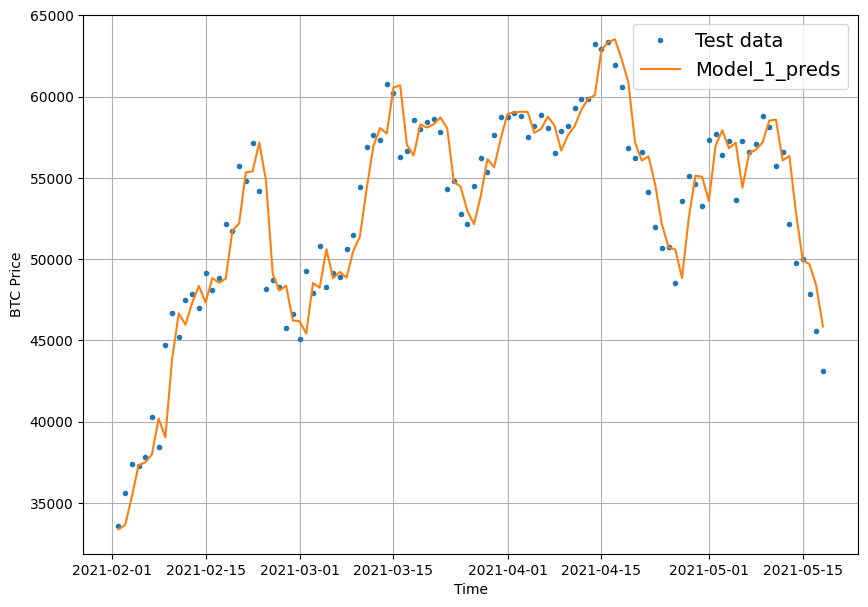

In [168]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test data"
)

plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_1_preds,
    start=offset,
    format="-",
    label="Model_1_preds"
)

Why our model lag ? This is due to autocorrelation:

https://otexts.com/fpp3/acf.html

## Model 2: Dense (window = 30, horizon = 1)

In [169]:
HORIZON = 1 # predict one step at a time (1 day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past (1 month)

In [170]:
# Make windows data with appropriate horiwon and window sizes
full_windows, full_labels = make_windows(prices, 
                                         window_size=WINDOW_SIZE, 
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [171]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [172]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [173]:
tf.random.set_seed(42)

# create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# compile
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [174]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 968us/step - loss: 623.9011


623.901123046875

In [175]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 848us/step - loss: 618.8535


618.853515625

In [176]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 921us/step


In [177]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 618.85364,
 'mse': 1303077.4,
 'rmse': 1141.5242,
 'mape': 2.834198,
 'mase': 1.0817622}

In [178]:
model_1_results

{'mae': 565.5482,
 'mse': 1161920.8,
 'rmse': 1077.9243,
 'mape': 2.5257013,
 'mase': 0.99351156}

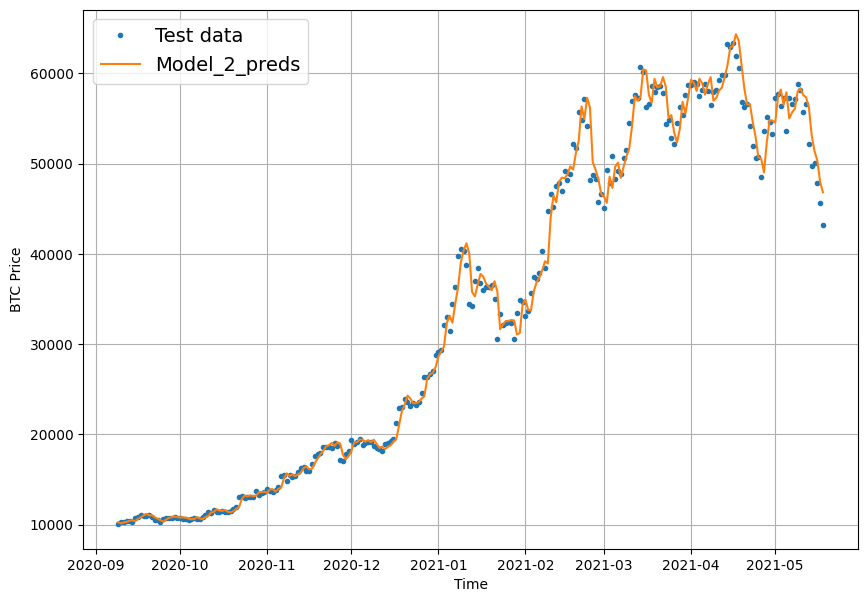

In [179]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test windows offset when plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test data"
)

plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_2_preds,
    start=offset,
    format="-",
    label="Model_2_preds"
)

## Model 3: Dense (window = 30, horizon = 7)

In [180]:
WINDOW_SIZE = 30
HORIZON = 7 # predicts 7 values at each timesteps

# Make windows data with appropriate horiwon and window sizes
full_windows, full_labels = make_windows(prices, 
                                         window_size=WINDOW_SIZE, 
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [181]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [182]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [183]:
tf.random.set_seed(42)

# create model (same as model_1 except with a different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# compile
model_3.compile(loss='MAE',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


In [184]:
# Evaluate model 3 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1338.6613


1338.6612548828125

In [185]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1234.4977


1234.4976806640625

In [186]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 986us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9454.988, 9032.537, 9421.765, 9528.852, 9589.421, 9715.785,
        9478.563],
       [9056.752, 8794.654, 9096.686, 9236.942, 9126.975, 9379.828,
        9254.668],
       [8707.913, 8637.683, 8855.981, 9002.733, 8919.703, 9257.323,
        9153.691],
       [8792.195, 9050.39 , 9037.587, 9183.001, 9194.786, 9313.148,
        9180.618],
       [8807.02 , 8958.463, 8867.365, 8953.368, 9060.467, 8941.149,
        8945.98 ]], dtype=float32)>

In [187]:
model_3_preds.shape, test_labels.shape, model_1_preds.shape

(TensorShape([551, 7]), (551, 7), TensorShape([556]))

In [188]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict 7 values)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  667.05804 ,   465.82562 ,   357.0385  ,   480.79477 ,
          379.054   ,   482.89752 ,   509.3524  ,   515.0701  ,
          562.9141  ,   566.89484 ,   625.2936  ,   701.2836  ,
          886.51746 ,   880.45013 ,   645.6571  ,   307.84467 ,
          197.02393 ,   224.36781 ,   167.10295 ,   201.72078 ,
          207.00871 ,   279.79395 ,   486.9405  ,   351.56808 ,
          283.76096 ,    93.737724,    77.97217 ,   110.72921 ,
          174.54443 ,   198.51172 ,   268.89752 ,   406.63324 ,
          333.09146 ,   316.9317  ,   318.4196  ,   289.6633  ,
          308.52496 ,   262.02066 ,   228.30762 ,   197.97664 ,
          423.91412 ,    66.06034 ,    76.597725,    64.72384 ,
           95.387764,   152.27393 ,    63.98919 ,   180.2613  ,
          133.33357 ,   149.2006  ,   162.59856 ,   129.02783 ,
          173.02371 ,   243.89432 ,   197.34221 ,   335.4388  ,
          566.8364  ,   481.04938 ,   496.45508 ,   541.3974  ,
          321.60678 ,   162.10115

## Make our evaluation function work for larger horizons

In [189]:
# Aggregating to a single value
tf.reduce_mean(model_3_results["mae"])

<tf.Tensor: shape=(), dtype=float32, numpy=1234.4977>

In [190]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value) (aggregation)
    # if multi-dimensional, aggregated to single values
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


In [191]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 1234.4977,
 'mse': 5351902.5,
 'rmse': 1419.7804,
 'mape': 5.5734453,
 'mase': 2.19672}

We've made and evaluated predictions with model_3, let's visualize.

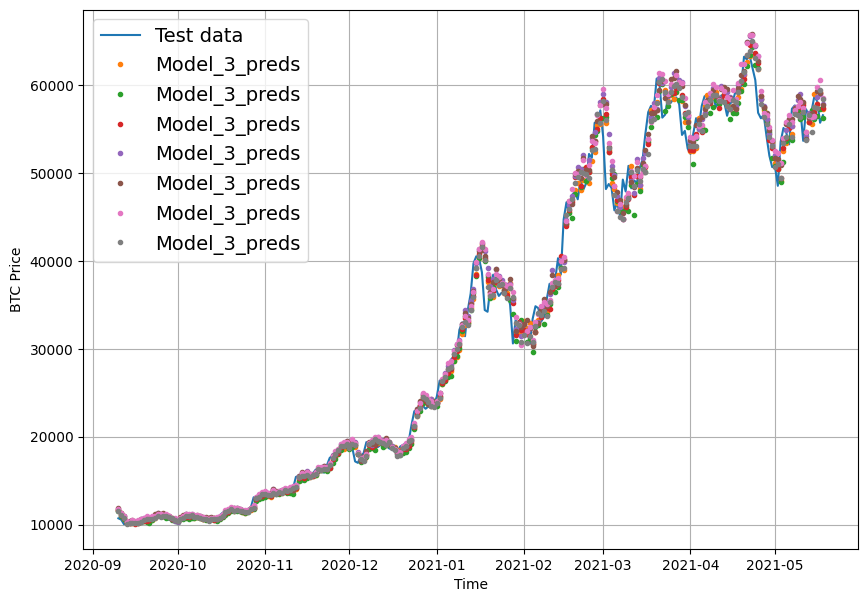

In [192]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    format="-",
    label="Test data"
)
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_3_preds,
    start=offset,
    format=".",
    label="Model_3_preds"
)

In [193]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9454.988, 9032.537, 9421.765, 9528.852, 9589.421, 9715.785,
       9478.563], dtype=float32)>

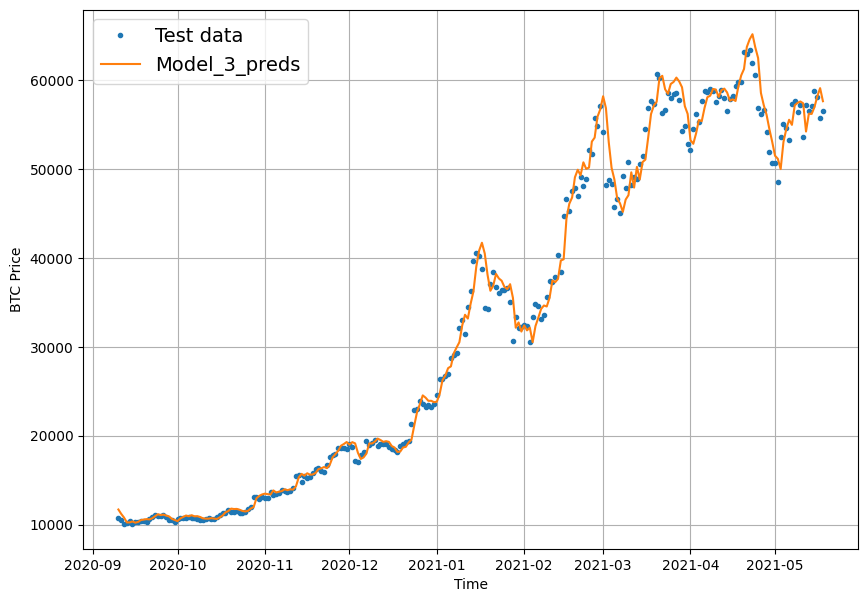

In [194]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test data"
)
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=tf.reduce_mean(model_3_preds, axis=1),
    start=offset,
    format="-",
    label="Model_3_preds"
)

## Which of our models is performing the best so far?

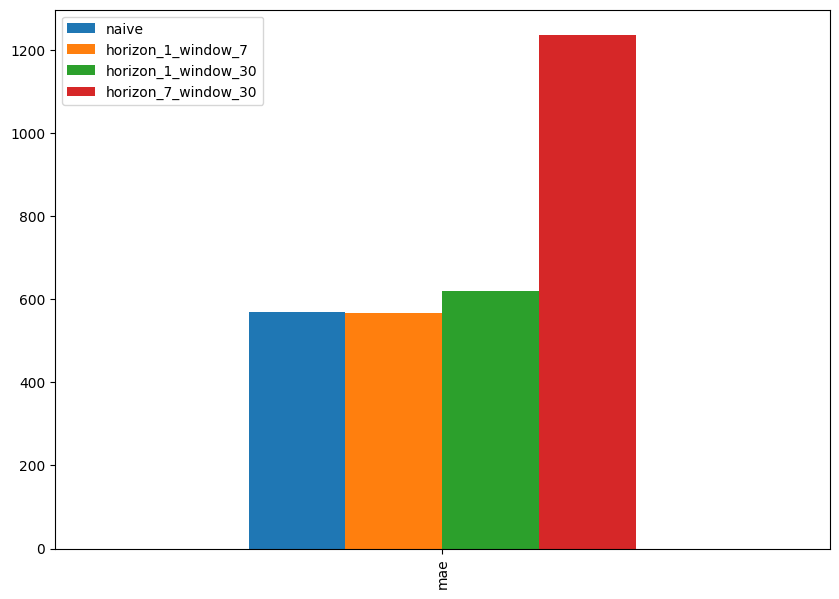

In [195]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D

<img src="course_images/10_time_series/10-bitcoin-forecast-in-seq2seq-terms.png" height="500">


In [199]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [201]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, We need an input shape of : `(batch_size, timesteps, input_dim)`...

However our data isn't that shape yet...

In [202]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [203]:
# Before we pass our data to the Con1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [205]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add extra dimension for `input_dim`

In [207]:
# test our our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dim_layer(x).shape}") # output = (7, 1)
print(f"Original values with expanded shape:\n {expand_dim_layer(x)}")
      

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [210]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, 
                  kernel_size=5, # sliding windows, looks to last x values
                  strides=1,
                  padding="causal", # temporal data
                  activation="relu"), 
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# compile
model_4.compile(loss='MAE',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


In [211]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_18 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [212]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 892us/step - loss: 679.5013


679.5013427734375

In [213]:
# Load
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 571.9178


571.9177856445312

In [214]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_1_preds[:10]

18/18 [==============================] - 0s 889us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8857.441 , 8758.465 , 9019.487 , 8771.895 , 8725.787 , 8749.8955,
       8679.242 , 8499.248 , 8465.069 , 8517.217 ], dtype=float32)>

In [215]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 571.9177,
 'mse': 1184362.4,
 'rmse': 1088.2842,
 'mape': 2.5586722,
 'mase': 1.004701}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we create previously.


In [220]:
tf.random.set_seed(42)

# let's build and LSTM model with Functionnal API
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x) # instead of activation=tanh
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])



Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2579.1421INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 85ms/step - loss: 2558.6003 - val_loss: 10581.7578
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 859.9941 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 740.5473 - val_loss: 1875.3074
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 242.8994INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 76ms/step - loss: 241.0812 - val_loss: 1328.5734
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 185.7491INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 184.3528 - val_loss: 1023.2451
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 179.3182 - val_loss: 1036.8405
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 176.4362INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 178.2484 - val_loss: 946.7285
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 176.3984INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 175.4995 - val_loss: 914.2689
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 174.4235 - val_loss: 998.0540
Epoch 9/100
18/18 [==============================] - 0s 17ms/step - loss: 175.3439 - val_loss: 988.2650
Epoch 10/100
18/18 [==============================] - 0s 17ms/step - loss: 173.4699 - val_loss: 966.6085
Epoch 11/100
18/18 [==============================] - 0s 16ms/step - loss: 171.5676 - val_loss: 952.4845
Epoch 12/100
18/18 [==============================] - 0s 16ms/step - loss: 172.2182 - val_loss: 951.1689
Epoch 13/100
18/18 [==============================] - 0s 17ms/step - loss: 167.8298 - val_loss: 957.1064
Epoch 14/100
18/18 [==============================] - 0s 16ms/step - loss: 165.5963 - val_loss: 962.6576
Epoch 15/100
18/18 [==============================] - 0s 16ms/step - loss: 165.3864 - val_loss: 919.8257
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 81ms/step - loss: 161.8536 - val_loss: 904.7454
Epoch 17/100
18/18 [==============================] - 0s 15ms/step - loss: 159.5903 - val_loss: 968.2210
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 160.6764INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 159.3961 - val_loss: 897.8049
Epoch 19/100
18/18 [==============================] - 0s 16ms/step - loss: 155.5194 - val_loss: 917.0482
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 154.4646INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 154.9269 - val_loss: 854.4378
Epoch 21/100
18/18 [==============================] - 0s 17ms/step - loss: 153.0407 - val_loss: 877.9932
Epoch 22/100
18/18 [==============================] - 0s 15ms/step - loss: 149.9568 - val_loss: 856.9446
Epoch 23/100
18/18 [==============================] - 0s 16ms/step - loss: 148.1595 - val_loss: 856.6801
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 148.8954INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 147.2397 - val_loss: 831.4348
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 149.8699INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 83ms/step - loss: 144.4004 - val_loss: 804.5323
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 144.9015INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 143.7485 - val_loss: 789.9615
Epoch 27/100
18/18 [==============================] - 0s 14ms/step - loss: 142.1702 - val_loss: 795.0739
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 138.9749INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 140.0218 - val_loss: 775.0764
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 141.6490INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 140.8833 - val_loss: 770.5036
Epoch 30/100
18/18 [==============================] - 0s 16ms/step - loss: 141.0265 - val_loss: 846.9474
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 138.2638INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 82ms/step - loss: 138.2759 - val_loss: 745.7911
Epoch 32/100
18/18 [==============================] - 0s 16ms/step - loss: 133.3484 - val_loss: 748.3218
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 132.8190INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 81ms/step - loss: 132.0392 - val_loss: 736.8491
Epoch 34/100
18/18 [==============================] - 0s 15ms/step - loss: 131.3131 - val_loss: 739.1030
Epoch 35/100
14/18 [======================>.......] - ETA: 0s - loss: 133.3312INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 132ms/step - loss: 129.9774 - val_loss: 715.1166
Epoch 36/100
14/18 [======================>.......] - ETA: 0s - loss: 128.8846INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 81ms/step - loss: 129.4003 - val_loss: 712.3780
Epoch 37/100
15/18 [========================>.....] - ETA: 0s - loss: 129.4030INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 127.3386 - val_loss: 708.0173
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 126.3701INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 126.2591 - val_loss: 694.8751
Epoch 39/100
18/18 [==============================] - 0s 15ms/step - loss: 126.0913 - val_loss: 705.7859
Epoch 40/100
14/18 [======================>.......] - ETA: 0s - loss: 126.9816INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 125.4503 - val_loss: 692.1070
Epoch 41/100
18/18 [==============================] - 0s 15ms/step - loss: 124.8320 - val_loss: 692.7975
Epoch 42/100
18/18 [==============================] - 0s 15ms/step - loss: 125.2800 - val_loss: 697.8141
Epoch 43/100
17/18 [===========================>..] - ETA: 0s - loss: 121.9711INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 122.1880 - val_loss: 666.7878
Epoch 44/100
15/18 [========================>.....] - ETA: 0s - loss: 121.5138INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 121.6784 - val_loss: 664.7020
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 118.1718INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 83ms/step - loss: 120.8230 - val_loss: 660.8619
Epoch 46/100
14/18 [======================>.......] - ETA: 0s - loss: 125.7439INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 122.7182 - val_loss: 654.6066
Epoch 47/100
18/18 [==============================] - 0s 17ms/step - loss: 121.6202 - val_loss: 659.3349
Epoch 48/100
17/18 [===========================>..] - ETA: 0s - loss: 120.8755INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 121.2046 - val_loss: 647.3625
Epoch 49/100
18/18 [==============================] - 0s 16ms/step - loss: 118.9365 - val_loss: 655.1332
Epoch 50/100
18/18 [==============================] - 0s 16ms/step - loss: 123.1827 - val_loss: 647.7899
Epoch 51/100
18/18 [==============================] - 0s 15ms/step - loss: 118.0981 - val_loss: 654.2491
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 118.1921INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 117.7945 - val_loss: 635.5386
Epoch 53/100
18/18 [==============================] - 0s 15ms/step - loss: 118.0592 - val_loss: 641.4078
Epoch 54/100
18/18 [==============================] - 0s 14ms/step - loss: 120.6534 - val_loss: 651.5128
Epoch 55/100
15/18 [========================>.....] - ETA: 0s - loss: 121.1377INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 117.4153 - val_loss: 628.4011
Epoch 56/100
18/18 [==============================] - 0s 15ms/step - loss: 119.8723 - val_loss: 656.2256
Epoch 57/100
18/18 [==============================] - 0s 14ms/step - loss: 127.4969 - val_loss: 656.5479
Epoch 58/100
18/18 [==============================] - 0s 14ms/step - loss: 117.0085 - val_loss: 635.1631
Epoch 59/100
14/18 [======================>.......] - ETA: 0s - loss: 115.9636INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 116.0691 - val_loss: 620.2750
Epoch 60/100
14/18 [======================>.......] - ETA: 0s - loss: 116.5398INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 78ms/step - loss: 115.5223 - val_loss: 619.3799
Epoch 61/100
18/18 [==============================] - 0s 15ms/step - loss: 115.6868 - val_loss: 640.0817
Epoch 62/100
18/18 [==============================] - 0s 15ms/step - loss: 116.5985 - val_loss: 632.9362
Epoch 63/100
18/18 [==============================] - 0s 15ms/step - loss: 118.8439 - val_loss: 621.8544
Epoch 64/100
18/18 [==============================] - 0s 15ms/step - loss: 114.5507 - val_loss: 626.9584
Epoch 65/100
14/18 [======================>.......] - ETA: 0s - loss: 115.8251INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 115.6401 - val_loss: 616.0507
Epoch 66/100
18/18 [==============================] - 0s 14ms/step - loss: 114.0374 - val_loss: 638.3330
Epoch 67/100
16/18 [=========================>....] - ETA: 0s - loss: 113.3996INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 115.9372 - val_loss: 610.3190
Epoch 68/100
18/18 [==============================] - 0s 14ms/step - loss: 116.9615 - val_loss: 628.9420
Epoch 69/100
18/18 [==============================] - 0s 14ms/step - loss: 121.1736 - val_loss: 628.8013
Epoch 70/100
14/18 [======================>.......] - ETA: 0s - loss: 117.4971INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 77ms/step - loss: 117.0945 - val_loss: 607.7687
Epoch 71/100
18/18 [==============================] - 0s 15ms/step - loss: 113.2618 - val_loss: 612.6521
Epoch 72/100
16/18 [=========================>....] - ETA: 0s - loss: 112.8388INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 79ms/step - loss: 114.4448 - val_loss: 605.5875
Epoch 73/100
16/18 [=========================>....] - ETA: 0s - loss: 112.4413INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 80ms/step - loss: 112.0526 - val_loss: 601.9145
Epoch 74/100
18/18 [==============================] - 0s 13ms/step - loss: 113.8241 - val_loss: 603.0751
Epoch 75/100
18/18 [==============================] - 0s 13ms/step - loss: 113.8305 - val_loss: 630.6225
Epoch 76/100
18/18 [==============================] - 0s 13ms/step - loss: 114.5885 - val_loss: 623.3722
Epoch 77/100
18/18 [==============================] - 0s 13ms/step - loss: 115.8959 - val_loss: 668.3967
Epoch 78/100
18/18 [==============================] - 0s 13ms/step - loss: 118.1924 - val_loss: 648.3706
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 114.3801INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 74ms/step - loss: 113.8895 - val_loss: 596.1457
Epoch 80/100
18/18 [==============================] - 0s 12ms/step - loss: 111.3853 - val_loss: 605.4294
Epoch 81/100
18/18 [==============================] - 0s 13ms/step - loss: 112.7090 - val_loss: 616.2324
Epoch 82/100
18/18 [==============================] - 0s 12ms/step - loss: 114.1938 - val_loss: 605.1932
Epoch 83/100
18/18 [==============================] - 0s 12ms/step - loss: 112.6371 - val_loss: 617.3801
Epoch 84/100
13/18 [====================>.........] - ETA: 0s - loss: 108.5873INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 74ms/step - loss: 112.6435 - val_loss: 594.7381
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 110.9990 - val_loss: 612.1250
Epoch 86/100
18/18 [==============================] - 0s 11ms/step - loss: 112.0967 - val_loss: 642.5970
Epoch 87/100
13/18 [====================>.........] - ETA: 0s - loss: 118.9016INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 136ms/step - loss: 114.7601 - val_loss: 592.7261
Epoch 88/100
18/18 [==============================] - 0s 10ms/step - loss: 112.6612 - val_loss: 604.8996
Epoch 89/100
18/18 [==============================] - 0s 12ms/step - loss: 110.6213 - val_loss: 653.3724
Epoch 90/100
18/18 [==============================] - 0s 12ms/step - loss: 119.4768 - val_loss: 649.8215
Epoch 91/100
18/18 [==============================] - 0s 12ms/step - loss: 116.9895 - val_loss: 658.8879
Epoch 92/100
18/18 [==============================] - 0s 11ms/step - loss: 111.4656 - val_loss: 595.0494
Epoch 93/100
18/18 [==============================] - 0s 11ms/step - loss: 113.3293 - val_loss: 594.9482
Epoch 94/100
18/18 [==============================] - 0s 11ms/step - loss: 110.0829 - val_loss: 606.5720
Epoch 95/100
13/18 [====================>.........] - ETA: 0s - loss: 110.0454INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 72ms/step - loss: 110.1498 - val_loss: 587.6232
Epoch 96/100
18/18 [==============================] - 0s 12ms/step - loss: 110.9980 - val_loss: 588.4274
Epoch 97/100
18/18 [==============================] - 0s 11ms/step - loss: 110.6861 - val_loss: 647.5112
Epoch 98/100
18/18 [==============================] - 0s 11ms/step - loss: 111.8696 - val_loss: 596.8857
Epoch 99/100
13/18 [====================>.........] - ETA: 0s - loss: 105.8369INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 73ms/step - loss: 109.6784 - val_loss: 586.2825
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 111.3746 - val_loss: 587.1483


In [221]:
# Load in best model 5 and evalute on test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 586.2824


586.2824096679688

In [222]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8917.572, 8777.163, 8954.292, 8784.071, 8719.12 ], dtype=float32)>

In [223]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 586.2825,
 'mse': 1232607.2,
 'rmse': 1110.2285,
 'mape': 2.6353383,
 'mase': 1.029936}

In [224]:
model_1_results

{'mae': 565.5482,
 'mse': 1161920.8,
 'rmse': 1077.9243,
 'mape': 2.5257013,
 'mase': 0.99351156}